# The Travelling Salesman Problem

You can run a cell either by clicking `Run` on the toolbar or by pressing `CTRL+RETURN`. Pressing `SHIFT+RETURN` will run the cell and move the pointer to the next one. For a complete list of keyboard shortcuts press `H`.

## Introduction

In this Jupyter notebook we are going to model the travelling salesman problem together. We will use visualizations extencively to make sure that you can easily follow the process. We encourage you to also use visualizations when you are working alone.  
Now, let us define the problem.

Given an undirected graph $G=(V,E)$, as well as edge weights (costs) $c: E \mapsto \mathbb{R}_+$, we need to find the *shortest* (or the cheapest) tour $T \subseteq E$.  
A tour is a Hamiltonian cycle, i.e., a cycle that contains each node in $V$ exactly once.

Run the cell below to import all the necessary libraries. In this case we import `Gurobi` and `matplotlib`. The second library will be used for plotting a couple of graphs later.

In [1]:
from gurobipy import *
import matplotlib.pyplot as plt

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Data

Below you will find the data supplied by your professor/manager/friend/etc.  
The following data is available to you:  
`V`: a dictionary containing verticies $v\in V$ as keys and their coordinates $(x, y)$ as values  
`E`: a dictionary containing edges $ij\in E$ as keys and their weights $c_{ij}\in \mathbb{R}_+$ as values  
`n`: the number of vertices

For the sake of simlicity, $G$ is a complete graph, i.e., $ij \in E$ $\forall i, j \in V$. The weight of an edge $ij\in E$ equals to the Manhattan distance from $i$ to $j$.

In [2]:
V = {
    0: (7, 1),
    1: (8, 7),
    2: (6, 4),
    3: (1, 5),
    4: (9, 4),
    5: (3, 9),
    6: (3, 4),
    7: (2, 2)
}

E = {(i, j): abs(V[i][0] - V[j][0]) + abs(V[i][1] - V[j][1]) for i, j in itertools.combinations(V, 2)}

# E = {(i, j): ((V[i][0] - V[j][0])**2 + (V[i][1] - V[j][1])**2)**(1/2)for i, j in itertools.combinations(V, 2)}

n = len(V)

In this notebook we will implement the Miller, Tucker, and Zemlin model from 1960.  
First, we need to convert each edge in $E$ into two directed edges and add them to $A$ (see lecture).  
From now on we will be working with the directed graph $D=(V,A)$.  
Note that the edge costs $c_{ij}, ij\in A$ are stored in a dictionary and can be accessed at `A[i,j]`.

In [3]:
A = dict()
for i, j in E:
    A[i, j] = E[i, j]
    A[j, i] = E[i, j]

Let us start by plotting our graph. We'll define a helper function `plot_graph()`.<br/>
Reference: [Variable Attributes](https://www.gurobi.com/documentation/9.0/refman/variable_attributes.html)

In [4]:
def plot_graph(model=None):
    plt.figure(figsize=(6, 6))
    
    # Plot edges
    for i, j in A:
        x1, y1 = V[i]
        x2, y2 = V[j]
        if model is not None and model.getVarByName(f'x[{i},{j}]').x > 0.5:
            plt.plot((x1, x2), (y1, y2), color='r')
        else:
            plt.plot((x1, x2), (y1, y2), lw=.4, color='k', ls='--')
        
    # Plot vertices
    for v in V:
        x, y = V[v]
        plt.plot(x, y, markersize=20, color='lightcoral', marker='o')
        plt.text(x, y, v, fontsize=14, color='k', va='center', ha='center')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

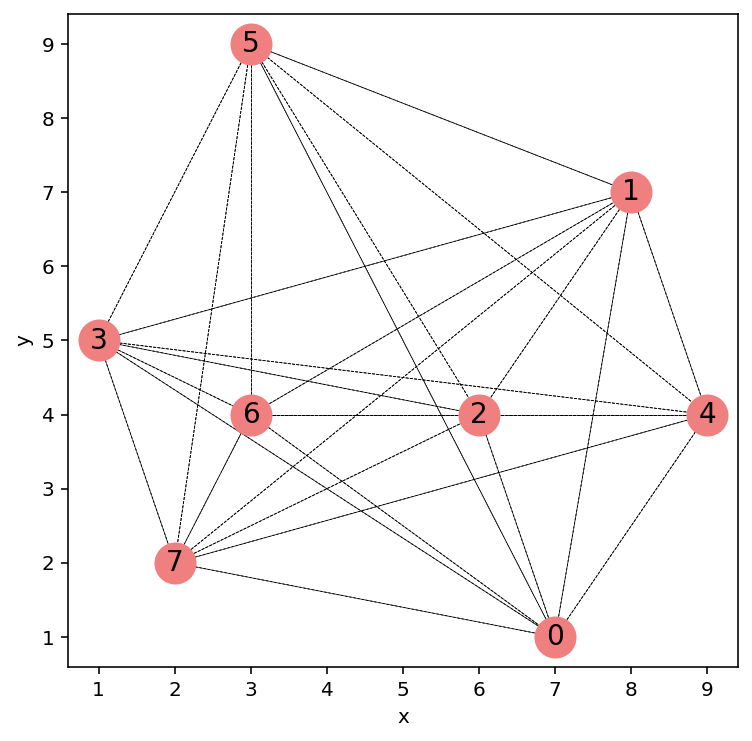

In [5]:
plot_graph()

## Model

We start off by creating an empty model `m`.<br>
Reference: [Model()](https://www.gurobi.com/documentation/9.0/refman/py_model2.html)

In [6]:
m = Model('TSP')

Using license file /Users/hhk/gurobi.lic
Academic license - for non-commercial use only


Then we add the necessary variables.  
In our case, we will need $|V|^2$ binary variables. The variables, let us call them $x_{ij}$, will depict whether the edge $ij \in A$ is a part of the optimal tour or not.  
Reference: [addVars()](https://www.gurobi.com/documentation/9.0/refman/py_model_addvars.html)

In [7]:
x = m.addVars(n, n, vtype=GRB.BINARY, name='x')

Now, before we can start constructing our model, we need to formulate the objective function and the constraints "on paper".  
We want to minimize the total weight of the edges that are a part of our tour. Hence, our objective function can be written as
$$min \sum_{ij\in A}c_{ij}x_{ij}$$
We will use the efficient function `quicksum()` provided in the `Gurobi` library.<br>
Reference: [setObjective()](https://www.gurobi.com/documentation/9.0/refman/py_model_setobjective.html), [quicksum()](https://www.gurobi.com/documentation/9.0/refman/py_quicksum.html)

In [8]:
m.setObjective(quicksum(A[i,j] * x[i,j] for i, j in A))

Since a tour is a cycle, we want to make sure that every vertex is visited and left only once.  
We enter each vertex once
$$\sum_{ij \in \delta^-(j)}x_{ij}=1 \quad \forall j \in V$$
and leave each vertex once
$$\sum_{ij \in \delta^+(i)}x_{ij}=1 \quad \forall i \in V$$
Let us add these constraints to our model. We will once again use the `quicksum()` method.  
Reference: [addConstrs()](https://www.gurobi.com/documentation/9.0/refman/py_model_addconstrs.html), [quicksum()](https://www.gurobi.com/documentation/9.0/refman/py_quicksum.html)

In [9]:
# Enter
m.addConstrs(quicksum(x[i, j] for i, j in A if j == v) == 1 for v in V)

# Leave
m.addConstrs(quicksum(x[i, j] for i, j in A if i == v) == 1 for v in V)

m.update()

We'll run the model once without adding any constraints to see what happens.  
Reference: [optimize()](https://www.gurobi.com/documentation/9.0/refman/py_model_optimize.html)

In [10]:
m.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 16 rows, 64 columns and 112 nonzeros
Model fingerprint: 0xf9c3376d
Variable types: 0 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 54.0000000
Presolve removed 0 rows and 8 columns
Presolve time: 0.00s
Presolved: 16 rows, 56 columns, 112 nonzeros
Variable types: 0 continuous, 56 integer (56 binary)

Root relaxation: objective 3.400000e+01, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      34.0000000   34.00000  0.00%     -    0s

Explored 0 nodes (15 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 34 54 

Optimal 

Let us plot the solution and print out the length of the shortest tour.<br/>
Reference: [ObjVal](https://www.gurobi.com/documentation/9.0/refman/objval.html)

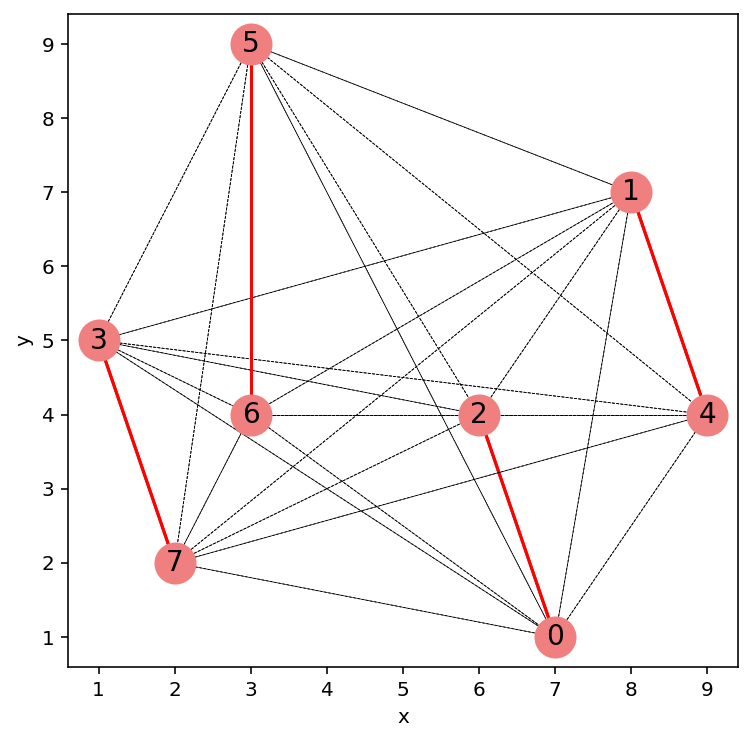

The length of the shortest tour is 34


In [11]:
plot_graph(m)
print('The length of the shortest tour is', round(m.ObjVal))

Oh, the current optimal solution consists of multiple subtours. Note that these are indeed subtours, each subtour is a cycle $i \rightarrow j \rightarrow i$. We do not want to allow such solutions, hence, we need to implement subtour elimination constraints (SEC). In the Miller, Tucker, and Zemlin model these constraints are written as
$$u_i - u_j + nx_{ij}\leq n-1 \quad \forall ij \in A, j \neq 1$$
where $u_i, i \in V$ is an integer variable determining the position of the vertex $i$ in a tour.  
First we add the variables $u_i$.  
Reference: [addVars()](https://www.gurobi.com/documentation/9.0/refman/py_model_addvars.html)

In [12]:
u = m.addVars(n, name='u', vtype=GRB.INTEGER)

Now we can arbitrarily fix the starting vertex and add the SECs.  
Reference: [addConstr()](https://www.gurobi.com/documentation/9.0/refman/py_model_addconstr.html), [addConstrs()](https://www.gurobi.com/documentation/9.0/refman/py_model_addconstrs.html)

In [13]:
m.addConstr(u[0] == 0)
m.addConstrs(u[i] - u[j] + n * x[i,j] <= n - 1 for i, j in A if j != 0)
m.update()

Run the optimization.<br/>
Reference: [optimize()](https://www.gurobi.com/documentation/9.0/refman/py_model_optimize.html)

In [14]:
m.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 66 rows, 72 columns and 260 nonzeros
Model fingerprint: 0x0e2c1851
Variable types: 0 continuous, 72 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]

MIP start from previous solve did not produce a new incumbent solution

Found heuristic solution: objective 50.0000000
Presolve removed 1 rows and 9 columns
Presolve time: 0.00s
Presolved: 65 rows, 63 columns, 252 nonzeros
Variable types: 0 continuous, 63 integer (56 binary)

Root relaxation: objective 3.425000e+01, 26 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   34.25000    0   14   50.00000   34.25000  31.5%     -    0s
H    0     0                      42.0000000   34.25000  18.5%     - 

Let us plot the new solution.

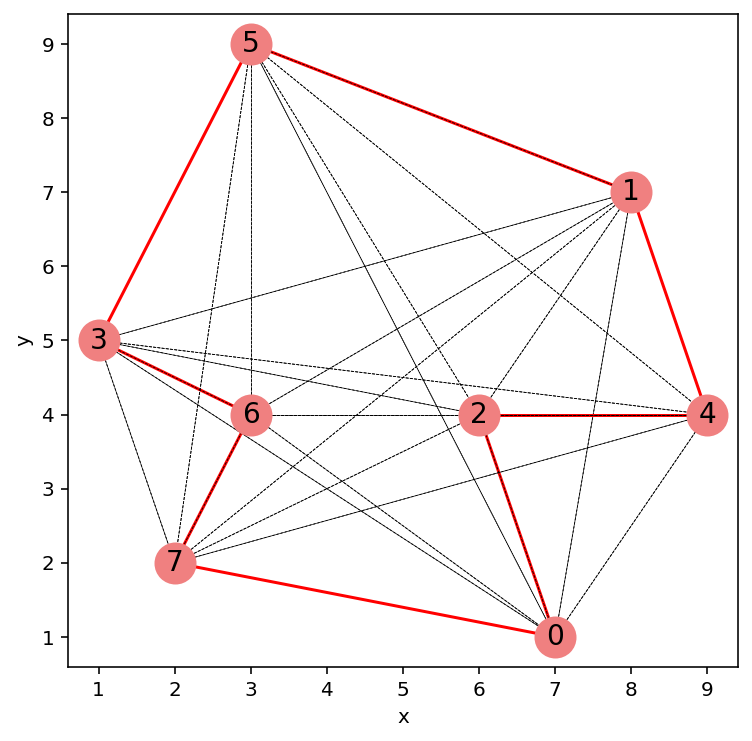

The length of the shortest tour is 36


In [15]:
plot_graph(m)
print('The length of the shortest tour is', round(m.ObjVal))

Our optimal solution is indeed a tour which means that we are done with the task. Congrats!

## Complications

Now, since we are driving a car, and cars consume fuel, we additionally need to make sure that we never run out of fuel on our journey. Each vertex has a gas station which will be able to provide us at most $f_v, v \in V$ units of fuel. We need exactly 1 unit of fuel to drive 1 unit of distance. As previously, we start our tour at the vertex 0. We start with an empty tank which we can immediately fill up for up to $f_0$ units of fuel. Keep in mind the our car has a limited tank capacity $b$. Our task is to find a shortest tour covering all vertices while ensuring that we are not going to run out of gas.

In [16]:
f = {
    0: 5,
    1: 5,
    2: 10,
    3: 2,
    4: 8,
    5: 3,
    6: 7,
    7: 5
}

b = 12

First, we add the variable $y_v$ which indicates how much fuel we have when we arrive at vertex $v \in V$.

In [17]:
y = m.addVars(n, name='y', vtype=GRB.INTEGER)
m.update()

Then we add the necessary constraints:
1. We start with an empty tank:
$$y_0 = 0$$
2. We respect the tank capacity:
$$y_v + f_v \leq b\quad \forall v\in V$$
3. If we go from $i$ to $j$, we fill up our tank at $i$ and burn $c_{ij}$ units of fuel while driving:
$$\text{ if } x_{ij}=1 \text{:} \quad y_j \leq y_i - c_{ij}+f_i \quad \forall ij\in A, j \neq 0$$

In [18]:
# Start with empty tank
m.addConstr(y[0] == 0)

# Max tank capacity
m.addConstrs(y[v] + f[v] <= b for v in V)

# Calculate the amount of fuel in the tank
m.addConstrs((x[i,j] == 1) >> (y[j] <= y[i] - A[i,j] + f[i]) for i, j in A if j != 0)

m.update()

Note that the bitwise operator `>>` used in the previous cell is currently not supported by TutOR.  
Let us now run the optimization and plot the solution.

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 75 rows, 80 columns and 269 nonzeros
Model fingerprint: 0xe171ae24
Model has 49 general constraints
Variable types: 0 continuous, 80 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 36 (0.00s)
Loaded MIP start from previous solve with objective 36

Presolve added 23 rows and 0 columns
Presolve removed 0 rows and 17 columns
Presolve time: 0.00s
Presolved: 98 rows, 63 columns, 342 nonzeros
Variable types: 0 continuous, 63 integer (49 binary)

Root relaxation: objective 3.425000e+01, 29 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0        36.00000   36.00000  0.00%

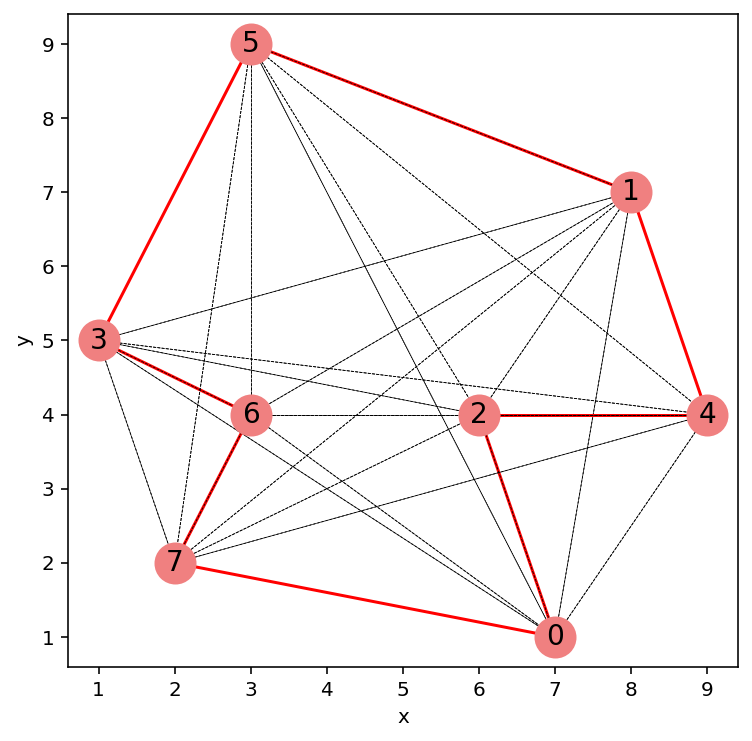

In [19]:
m.optimize()
plot_graph(m)

Note, that the previous tour was not feasible with the new fuel restictions and a new tour has been found.  
Lastly, we are suddenly informed that the edges (1, 5) and (2, 6) are no longer available. We should update our model accordingly.  
Reference: [addConstr()](https://www.gurobi.com/documentation/9.0/refman/py_model_addconstr.html)

In [20]:
m.addConstr(x[1,5] == 0)
m.addConstr(x[5,1] == 0)
m.addConstr(x[2,6] == 0)
m.addConstr(x[6,2] == 0)
m.update()

We optimize one last time...

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 79 rows, 80 columns and 273 nonzeros
Model fingerprint: 0x858f6480
Model has 49 general constraints
Variable types: 0 continuous, 80 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R75 by 1.000000000

Presolve added 17 rows and 0 columns
Presolve removed 0 rows and 21 columns
Presolve time: 0.00s
Presolved: 96 rows, 59 columns, 324 nonzeros
Variable types: 0 continuous, 59 integer (45 binary)

Root relaxation: objective 3.450000e+01, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   34.50000    0   12          -   34.5

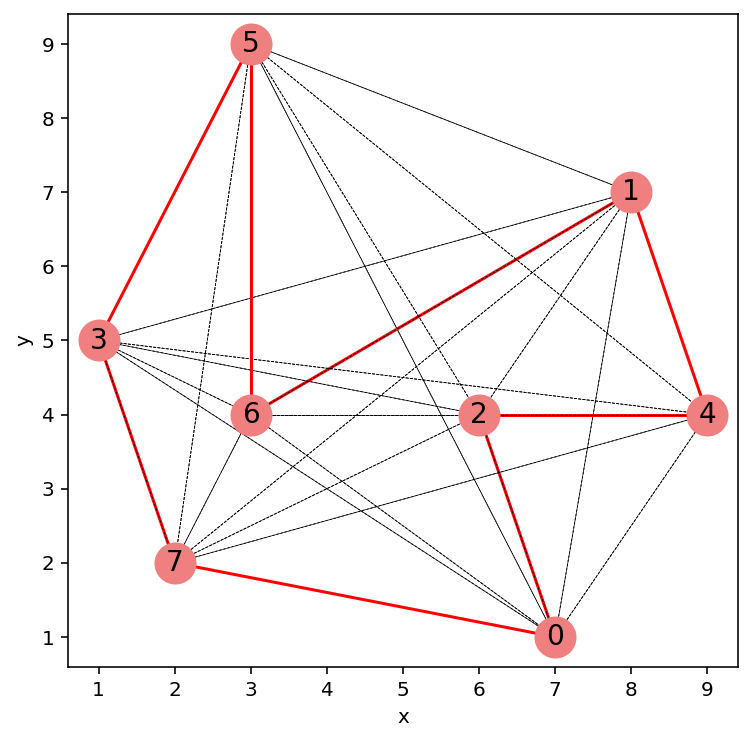

In [21]:
m.optimize()
plot_graph(m)

We see that neither (1, 5) nor (2, 6) have been used in this shortest tour. Great job!

## Conclusion

In this notebook you have modeled the travelling salesman problem as well as its slight variation.  
We have also used graphs to visualize the solutions and to see the effect of the constraints as we added them.

We hope you found this notebook interesting. All the best and until next time!